In [1]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 


In [67]:
! ls ./Data

MD_LS_energy1000_scan1.h5  MD_LS_energy5000_scan1.h5  MD_LS_sim3000.h5
MD_LS_energy3000_scan2.h5  MD_LS_sim1000.h5


In [3]:
def erfunc(x,a,b,c,d):
	return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

In [85]:
datafile_1000 = "./Data/MD_LS_energy1000_scan1.h5"
sim_file_1000 = "./Data/MD_LS_sim1000.h5"
datafile_3000 = "./Data/MD_LS_energy3000_scan2.h5"
sim_file_3000 = "./Data/MD_LS_sim3000.h5"
datafile_5000 = "./Data/MD_LS_energy5000_scan1.h5"
sim_file_5000 = "./Data/MD_LS_sim5000.h5"

In [86]:
LSdata_data_1000 = pd.read_hdf(datafile_1000, key='LSdata') 
LSsim_data_1000 = pd.read_hdf(sim_file_1000, key='LSdata')
metadata_data_1000 = pd.read_hdf(datafile_1000, key='metadata')
metadata_sim_1000 = pd.read_hdf(sim_file_1000, key='metadata')

LSdata_data_3000 = pd.read_hdf(datafile_3000, key='LSdata') 
LSsim_data_3000 = pd.read_hdf(sim_file_3000, key='LSdata')
metadata_data_3000 = pd.read_hdf(datafile_3000, key='metadata')
metadata_sim_3000 = pd.read_hdf(sim_file_3000, key='metadata')


LSdata_data_5000 = pd.read_hdf(datafile_5000, key='LSdata') 
LSsim_data_5000 = pd.read_hdf(sim_file_5000, key='LSdata')
metadata_data_5000 = pd.read_hdf(datafile_5000, key='metadata')
metadata_sim_5000 = pd.read_hdf(sim_file_5000, key='metadata')

In [74]:
def linscan_data(LSdata_data, metadata_data):

    fig, ax = plt.subplots(figsize=(10,5))	


    params = metadata_data['param0'].iloc[0], metadata_data['param1'].iloc[0], metadata_data['param2'].iloc[0], metadata_data['param3'].iloc[0]

    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')

    # distance between centre of channeled beam and primary beam envelope
    deltax = metadata_data['deltax'].iloc[0]
    PosEnvelope = metadata_data['PosEnvelope'].iloc[0]
    RangetoMeanEnv = metadata_data['RangetoMeanEnv_min'].iloc[0], metadata_data['RangetoMeanEnv_max'].iloc[0]

    theta_calc = metadata_data['theta_calc'].iloc[0] #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))

    #ax.plot(LSdata_data.CollPos, abs(params[1])*norm.pdf(LSdata_data.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')
    #ax.errorbar(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, yerr=LSdata_data.BLM_Coll_Err_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, erfunc(LSdata_data.CollPos, *params), label='Fit', zorder=10)

    #ax.plot(LSdata_data.CollPos, m * LSdata_data.CollPos + q, color='green', label='Channeled beam profile')

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    ax.set_ylabel('BLM signal (flux-normalized) [a.u.]', fontsize=12)

    ax.hlines(y=1, xmin=PosEnvelope-RangetoMeanEnv[0], xmax=PosEnvelope+RangetoMeanEnv[1], linewidth=2, color='k', linestyles='--')

    ax2 = ax.twiny()
    ax2.plot(LSdata_data.CollPos_thetaframe, LSdata_data.BLM_Coll_norm, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)


    # ax.get_yaxis().set_visible(False)
    ax.set_ylim(0,2.5)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    # ax.yaxis.grid(False)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    lines1, labels1 = ax.get_legend_handles_labels()
    plt.legend(lines1, labels1, fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    ax2.axvline(0, color='grey', linestyle='--')

    #ax.axvline(PosMaxErfFit, color='r', linestyle='--')

    #ax.set_title(f'B2H LINEAR SCAN     Energy: {energy} GeV', fontsize=14)


In [75]:
def linscan_sim(LSsim_data, metadata_sim):
    
    beta_CRY = metadata_sim['beta_CRY'].iloc[0] 
    beta_COLL = metadata_sim['beta_COLL'].iloc[0]
    deltaphi_CRY_COLL = metadata_sim['deltaphi_CRY_COLL'].iloc[0]
    PosEnvelope = metadata_sim['PosEnvelope'].iloc[0] 
    PosMaxErfFit = metadata_sim['PosMaxErfFit'].iloc[0]   
    normalize = metadata_sim['normal'].iloc[0]
   

    def erfunc(x,a,b,c,d):
        return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

    params = metadata_sim['param0'].iloc[0], metadata_sim['param1'].iloc[0], metadata_sim['param2'].iloc[0], metadata_sim['param3'].iloc[0] # extras = opt.curve_fit(erfunc, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].CollPos, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].Counts, p0=param0)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(LSsim_data.CollPos, LSsim_data.Counts)
    #ax.plot(LSdata.CollPos, erfunc(LSdata.CollPos, param0[0], param0[1], param0[2], param0[3]))
    ax.plot(LSsim_data.CollPos, erfunc(LSsim_data.CollPos, params[0], params[1], params[2], params[3]))
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
    ax.axvline(PosMaxErfFit, color='r', linestyle='--')
    ax.axvline(PosEnvelope, color='g', linestyle='--')
    ax.axhline(1, color='b', linestyle='--')


    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')


    # distance between centre of channeled beam and primary beam envelope
    deltax = (abs(params[2])-abs(PosEnvelope))

    theta_calc = metadata_sim['theta_calc'].iloc[0] # (deltax-self.n_sigma*np.sqrt(self.emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))



    ax2 = ax.twiny()
    ax2.plot(LSsim_data.CollPos_thetaframe, LSsim_data.Counts, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)
    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    #ax.plot(self.LSdata.CollPos, 0.0001*abs(params[1])*norm.pdf(self.LSdata.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')

    efficiency = round(abs(params[1])*100,2)
    print('Efficiency: ', efficiency, '%')
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    return ax



In [76]:
def linscan_merge(LSdata_data, metadata_data, LSsim_data_orig, metadata_sim):

    fig, ax = plt.subplots(figsize=(10,5))	
    LSsim_data = copy.deepcopy(LSsim_data_orig)
    LSsim_data.CollPos = LSsim_data.CollPos*1e3

    PosEnvelope_sim = metadata_sim['PosEnvelope'].iloc[0]  *1e3

    params = metadata_data['param0'].iloc[0], metadata_data['param1'].iloc[0], metadata_data['param2'].iloc[0], metadata_data['param3'].iloc[0]
    params_sim = metadata_sim['param0'].iloc[0], metadata_sim['param1'].iloc[0], metadata_sim['param2'].iloc[0], metadata_sim['param3'].iloc[0]

    # distance between centre of channeled beam and primary beam envelope
    deltax = metadata_data['deltax'].iloc[0]
    PosEnvelope = metadata_data['PosEnvelope'].iloc[0]
    RangetoMeanEnv = metadata_data['RangetoMeanEnv_min'].iloc[0], metadata_data['RangetoMeanEnv_max'].iloc[0]

    denv = PosEnvelope - PosEnvelope_sim
    LSsim_data.CollPos = LSsim_data.CollPos + denv

    theta_calc = metadata_data['theta_calc'].iloc[0] #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    theta_calc_sim = metadata_sim['theta_calc'].iloc[0] #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    #ax.plot(LSdata_data.CollPos, abs(params[1])*norm.pdf(LSdata_data.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')
    #ax.errorbar(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, yerr=LSdata_data.BLM_Coll_Err_norm, label='Data', marker='o', markersize=5)
 
    ax.plot(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, erfunc(LSdata_data.CollPos, *params), label='Fit', zorder=10)

    #ax.plot(LSdata_data.CollPos, m * LSdata_data.CollPos + q, color='green', label='Channeled beam profile')

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    ax.set_ylabel('BLM signal (flux-normalized) [a.u.]', fontsize=12)

    ax.hlines(y=1, xmin=PosEnvelope-RangetoMeanEnv[0], xmax=PosEnvelope+RangetoMeanEnv[1], linewidth=2, color='k', linestyles='--')

    ax2 = ax.twiny()
    ax2.plot(LSdata_data.CollPos_thetaframe, LSdata_data.BLM_Coll_norm, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)


    # ax.get_yaxis().set_visible(False)
    ax.set_ylim(0,2.5)
    ax.set_xlim(0.0, 10)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    # ax.yaxis.grid(False)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    lines1, labels1 = ax.get_legend_handles_labels()
    plt.legend(lines1, labels1, fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)


    textstr = 'DATA Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    textstr_sim = '\nSIM Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc_sim*1.0e6,3),round(abs(params_sim[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.6, textstr+textstr_sim, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)


    ax2.axvline(0, color='grey', linestyle='--')

    ax.plot(LSsim_data.CollPos, LSsim_data.Counts, label='Sim')
    ax.axvline(PosEnvelope_sim +denv, color='r', linestyle='--')
    ax.axvline(PosEnvelope, color='g', linestyle='--')
    #ax.axvline(PosMaxErfFit, color='r', linestyle='--')

    #ax.set_title(f'B2H LINEAR SCAN     Energy: {energy} GeV', fontsize=14)
    return ax


# 1000 GeV

Height:  0.8730173668769929  a.u.
Mean:  0.006939690858775296  mm
Sigma:  0.0001717598709508704  mm
Calculated theta [urad]:  49.622
Efficiency:  87.3 %


(0.0, 2.5)

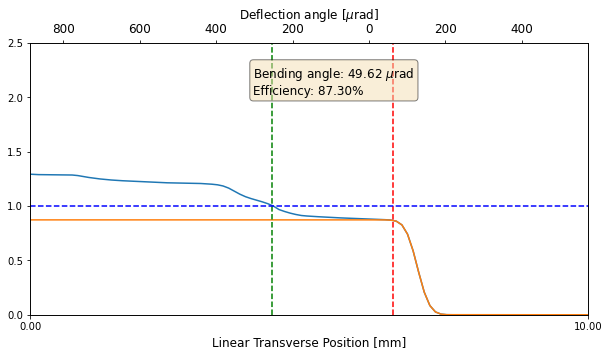

In [77]:
ax = linscan_sim(LSsim_data_1000, metadata_sim_1000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.8445982118176604  a.u.
Mean:  6.396392017220201  mm
Sigma:  0.24291239472268372  mm
Calculated theta [urad]:  50.088


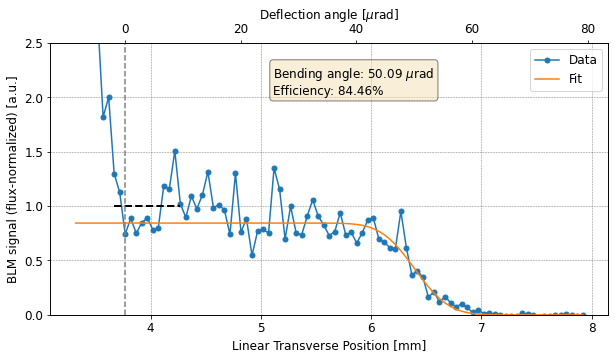

In [78]:
linscan_data(LSdata_data_1000, metadata_data_1000)

(3.0, 9.0)

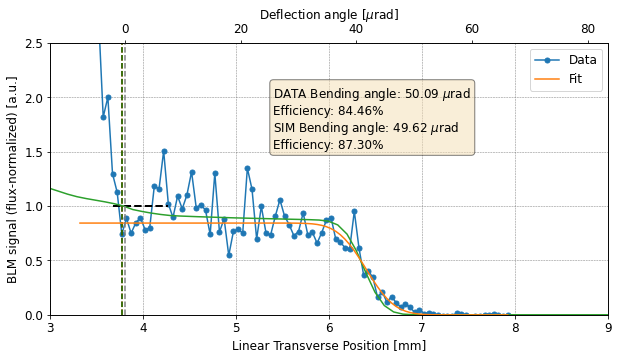

In [79]:
ax = linscan_merge(LSdata_data_1000, metadata_data_1000, LSsim_data_1000, metadata_sim_1000)
ax.set_xlim(3, 9)

# 3000 GeV

Height:  0.8286662224942495  a.u.
Mean:  0.005175003509387147  mm
Sigma:  9.421127749586289e-05  mm
Calculated theta [urad]:  49.59
Efficiency:  82.87 %


(0.0, 2.5)

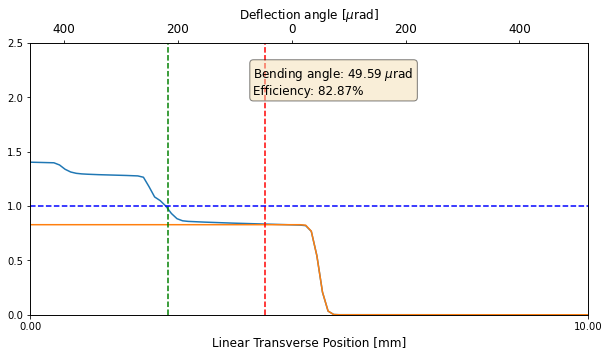

In [80]:
ax = linscan_sim(LSsim_data_3000, metadata_sim_3000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.6175904995957343  a.u.
Mean:  4.897564590133499  mm
Sigma:  0.2098949438543342  mm
Calculated theta [urad]:  50.085


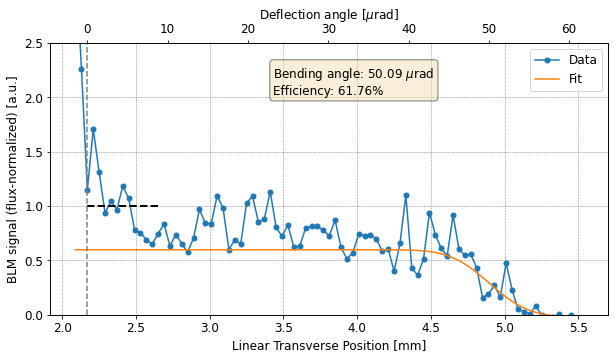

In [81]:
linscan_data(LSdata_data_3000, metadata_data_3000)

(1.5, 6.0)

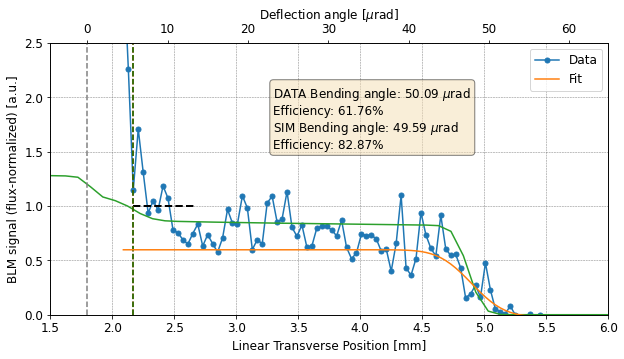

In [84]:
ax = linscan_merge(LSdata_data_3000, metadata_data_3000, LSsim_data_3000, metadata_sim_3000)
ax.set_xlim(1.5, 6)

# 5000 GeV

Height:  0.8115865913268562  a.u.
Mean:  0.004654539715295892  mm
Sigma:  6.780073026049329e-05  mm
Calculated theta [urad]:  49.598
Efficiency:  81.16 %


(0.0, 2.5)

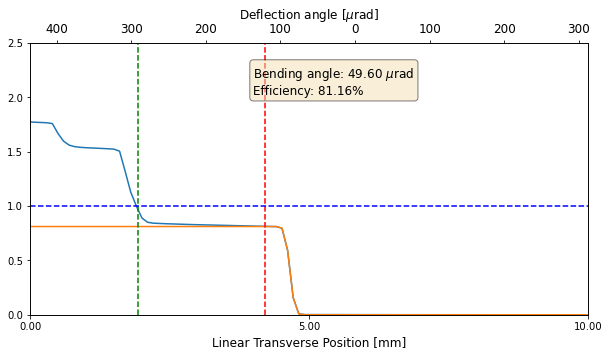

In [87]:
ax = linscan_sim(LSsim_data_5000, metadata_sim_5000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.4650799026811937  a.u.
Mean:  4.4737791481430005  mm
Sigma:  0.062073991572250936  mm
Calculated theta [urad]:  52.819


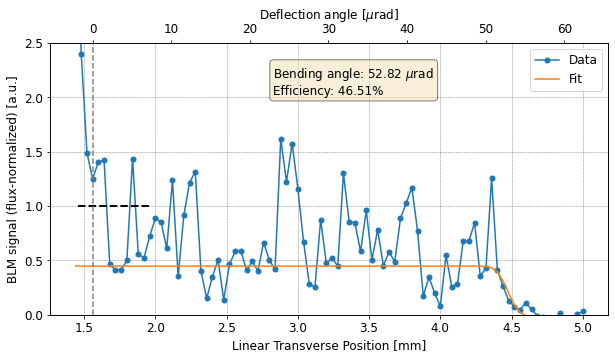

In [88]:
linscan_data(LSdata_data_5000, metadata_data_5000)

(1.0, 5.5)

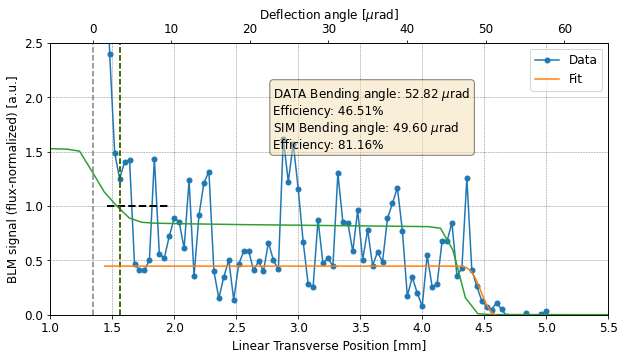

In [93]:
ax = linscan_merge(LSdata_data_5000, metadata_data_5000, LSsim_data_5000, metadata_sim_5000)
ax.set_xlim(1, 5.5)
